In [13]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD, Adagrad, RMSprop, Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping

# Load data
train_data = pd.read_csv('./task1/train_data.csv').values
train_labels = pd.read_csv('./task1/train_label.csv').values.ravel()

val_data = pd.read_csv('./task1/val_data.csv').values
val_labels = pd.read_csv('./task1/val_label.csv').values.ravel()

test_data = pd.read_csv('./task1/test_data.csv').values
test_labels = pd.read_csv('./task1/test_label.csv').values.ravel()

# Print dataset shapes
print("Train Data Shape:", train_data.shape)
print("Train Labels Shape:", train_labels.shape)
print("Validation Data Shape:", val_data.shape)
print("Validation Labels Shape:", val_labels.shape)
print("Test Data Shape:", test_data.shape)
print("Test Labels Shape:", test_labels.shape)

Train Data Shape: (1999, 36)
Train Labels Shape: (1999,)
Validation Data Shape: (499, 36)
Validation Labels Shape: (499,)
Test Data Shape: (499, 36)
Test Labels Shape: (499,)


In [14]:
# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,  # Minimum change in the monitored quantity to qualify as an improvement
    patience=25,       # Number of epochs with no improvement after which training will be stopped
    mode='min',       # In this case, we want to minimize the loss
    verbose=1
)

In [15]:
# Define the Model
def create_model():
    model = Sequential([
        Dense(20, activation='tanh', input_shape=(train_data.shape[1],)),
        Dense(10, activation='tanh'),
        Dense(len(np.unique(train_labels)), activation='softmax')  # Multi-class classification
    ])
    return model

In [16]:
optimizers = {
    "Delta Rule (SGD)": SGD(learning_rate=0.01),
    "Generalized Delta Rule (Momentum)": SGD(learning_rate=0.01, momentum=0.9),
    "AdaGrad": Adagrad(learning_rate=0.01),  # Reduce LR
    "RMSProp": RMSprop(learning_rate=0.01),  # Reduce LR
    "Adam": Adam(learning_rate=0.01)  # Keep Adam unchanged
}


In [17]:
# Train and Evaluate the Model with Different Optimizers
results = {}

In [18]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

for opt_name, optimizer in optimizers.items():
    print(f"\nTraining with {opt_name}...")

    model = create_model()
    model.compile(optimizer=optimizer, loss=SparseCategoricalCrossentropy(), metrics=['accuracy'])

    history = model.fit(train_data, train_labels, validation_data=(val_data, val_labels),
                        epochs=200, batch_size=1, verbose=1, callbacks=[early_stopping])

    # Evaluate on Train and Test Data
    train_loss, train_acc = model.evaluate(train_data, train_labels, verbose=0)
    test_loss, test_acc = model.evaluate(test_data, test_labels, verbose=0)

    # Generate Predictions
    y_train_pred = np.argmax(model.predict(train_data), axis=1)
    y_test_pred = np.argmax(model.predict(test_data), axis=1)

    # Compute Confusion Matrices
    train_cm = confusion_matrix(train_labels, y_train_pred)
    test_cm = confusion_matrix(test_labels, y_test_pred)

    # Compute F1-score Report
    train_f1_report = classification_report(train_labels, y_train_pred, output_dict=True)
    test_f1_report = classification_report(test_labels, y_test_pred, output_dict=True)

    # Store Results
    results[opt_name] = {
        "history": history.history,
        "train_loss": train_loss,
        "test_loss": test_loss,
        "train_accuracy": train_acc,
        "test_accuracy": test_acc,
        "train_cm": train_cm,
        "test_cm": test_cm,
        "train_f1_report": train_f1_report,
        "test_f1_report": test_f1_report,
        "epochs_trained": len(history.history['loss'])
    }



Training with Delta Rule (SGD)...
Epoch 1/200
1999/1999 [==============================] - 2s 843us/step - loss: 1.5426 - accuracy: 0.3112 - val_loss: 1.4277 - val_accuracy: 0.4369
Epoch 2/200
1999/1999 [==============================] - 2s 785us/step - loss: 1.3463 - accuracy: 0.4122 - val_loss: 1.3172 - val_accuracy: 0.4168
Epoch 3/200
1999/1999 [==============================] - 2s 845us/step - loss: 1.2570 - accuracy: 0.4677 - val_loss: 1.2621 - val_accuracy: 0.4569
Epoch 4/200
1999/1999 [==============================] - 1s 750us/step - loss: 1.2195 - accuracy: 0.4957 - val_loss: 1.2461 - val_accuracy: 0.4609
Epoch 5/200
1999/1999 [==============================] - 2s 779us/step - loss: 1.1987 - accuracy: 0.5003 - val_loss: 1.3128 - val_accuracy: 0.4529
Epoch 6/200
1999/1999 [==============================] - 2s 753us/step - loss: 1.1832 - accuracy: 0.5008 - val_loss: 1.2219 - val_accuracy: 0.4749
Epoch 7/200
1999/1999 [==============================] - 2s 777us/step - loss: 1.16

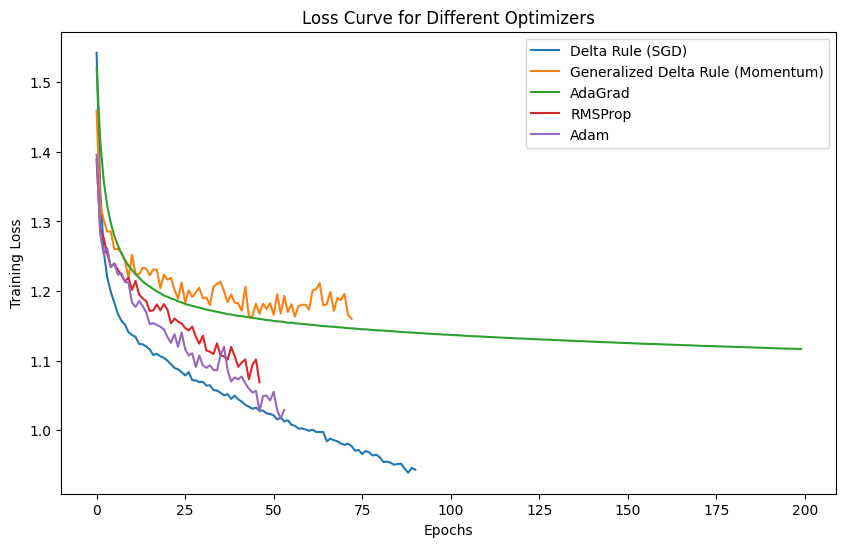

In [19]:
# Plot Training Loss Curves
plt.figure(figsize=(10, 6))
for opt_name, res in results.items():
    plt.plot(res["history"]['loss'], label=opt_name)
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.title("Loss Curve for Different Optimizers")
plt.legend()
plt.show()


Confusion Matrix - Training Data (Delta Rule (SGD)):


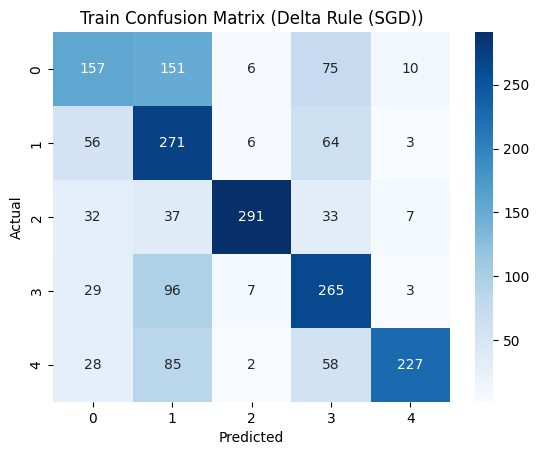


Confusion Matrix - Test Data (Delta Rule (SGD)):


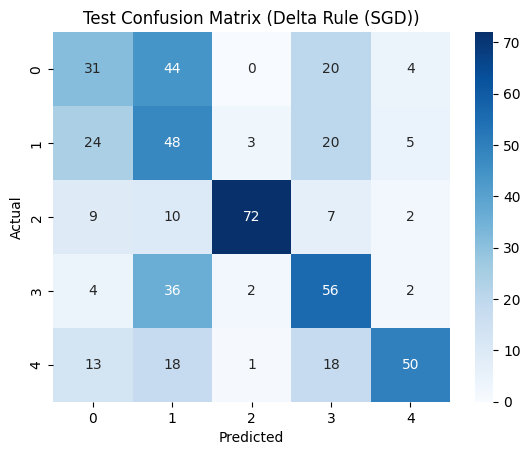


Confusion Matrix - Training Data (Generalized Delta Rule (Momentum)):


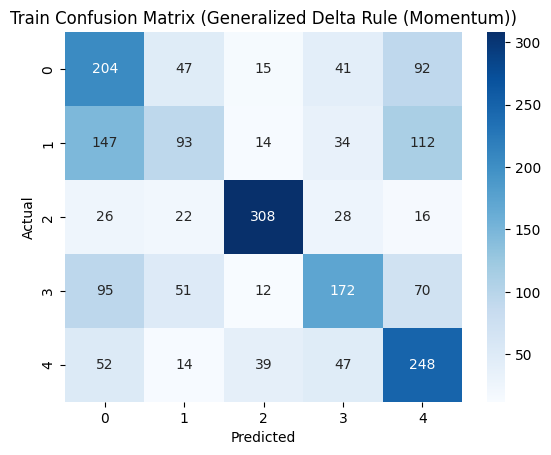


Confusion Matrix - Test Data (Generalized Delta Rule (Momentum)):


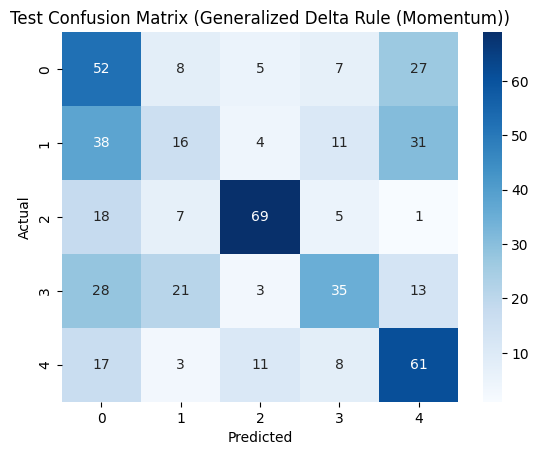


Confusion Matrix - Training Data (AdaGrad):


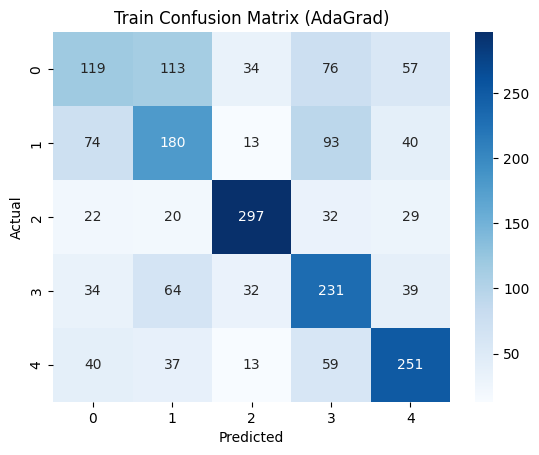


Confusion Matrix - Test Data (AdaGrad):


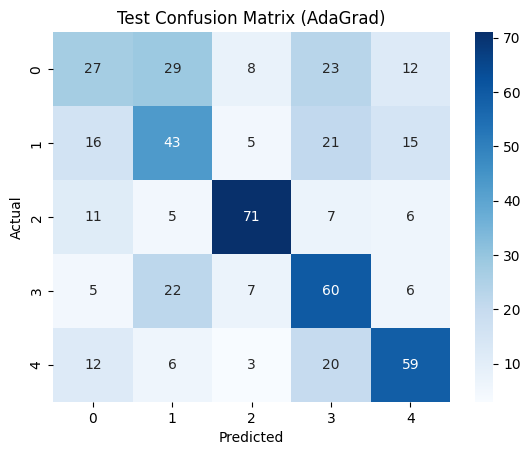


Confusion Matrix - Training Data (RMSProp):


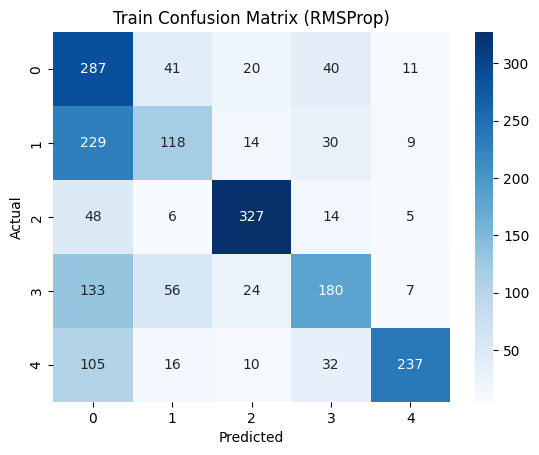


Confusion Matrix - Test Data (RMSProp):


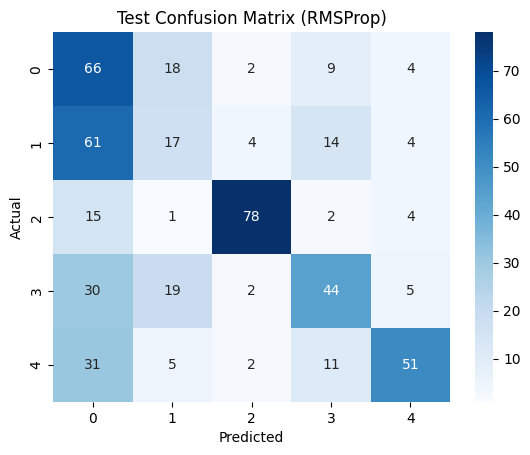


Confusion Matrix - Training Data (Adam):


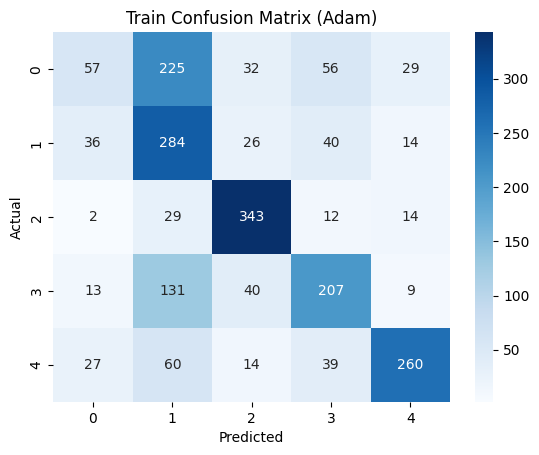


Confusion Matrix - Test Data (Adam):


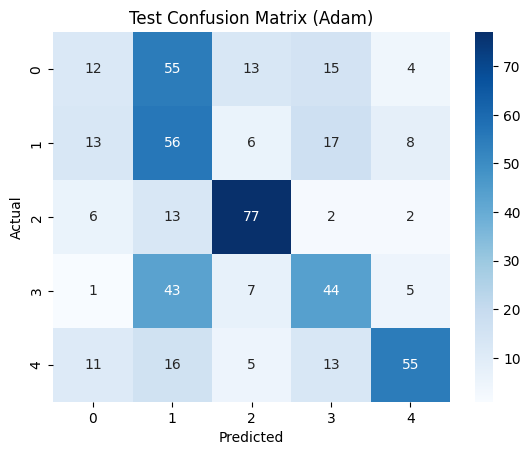


Comparison of Epochs for Convergence:
Delta Rule (SGD): 91 epochs
Generalized Delta Rule (Momentum): 73 epochs
AdaGrad: 200 epochs
RMSProp: 47 epochs
Adam: 54 epochs


In [20]:
# Display Confusion Matrices
for opt_name, res in results.items():
    print(f"\nConfusion Matrix - Training Data ({opt_name}):")
    sns.heatmap(res["train_cm"], annot=True, fmt='d', cmap="Blues")
    plt.title(f"Train Confusion Matrix ({opt_name})")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    print(f"\nConfusion Matrix - Test Data ({opt_name}):")
    sns.heatmap(res["test_cm"], annot=True, fmt='d', cmap="Blues")
    plt.title(f"Test Confusion Matrix ({opt_name})")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# Compare Convergence Speed
print("\nComparison of Epochs for Convergence:")
for opt_name, res in results.items():
    print(f"{opt_name}: {res['epochs_trained']} epochs")
